**【問題1】データの可視化**  
Matplotlibを使い標高データを可視化してください。横軸に「その地点の番号」、縦軸に「標高」を設定すれば、富士山の断面図が描けます。  
この断面図を見れば低い場所はすぐに分かりますが、今回は暗闇の中で足元の勾配のみが知れるという状況を想像します。

In [1]:
import numpy as np
csv_path = "mtfuji_data.csv" # ファイル名（パス）を指定する
np.set_printoptions(suppress=True) # 指数表示の禁止を設定する
fuji = np.loadtxt(csv_path, delimiter=",", skiprows=1)

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

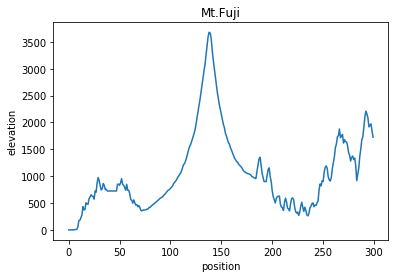

In [3]:
plt.plot(fuji[:, 0], fuji[:, 3])
plt.xlabel('position')
plt.ylabel('elevation')
plt.title('Mt.Fuji')
plt.show()

**【問題2】ある地点の勾配を計算する関数を作成**  
「二次元配列と勾配問題」では各地点での勾配を最初に求めました。しかし、暗闇の富士山を想像すると、知ることができるのは今いる地点の勾配だけです。  
「今いる地点の番号」と「今いる隣の地点の番号（今いる地点の番号-1）」の関係による勾配を求める関数を作成してください。  
勾配は以下の式で求まりましたが、このデータでは「標高」がy、「その地点の番号」がxに相当します。  
勾配 = yの変化量/xの変化量

In [4]:
def calc_gradient(now_position):
    if now_position <= 0:
        gradient = 0
    else:
        elevation = fuji[:, 3][now_position] - fuji[:, 3][now_position - 1]
        position_num = fuji[:, 0][now_position] - fuji[:, 0][now_position - 1]
        gradient = elevation / position_num
    return gradient

gradient = calc_gradient(100)
print(gradient)

18.90000000000009


**【問題3】移動先の地点を計算する関数を作成**  
今いる地点の勾配の情報を元に、次に移動先の地点を計算する関数を作成してください。  
数式で表すと「移動先の地点 = 今いる地点 - α ×今いる地点の勾配」となります。  
「今いる地点の勾配」は問題2で作成した関数の返り値を使用してください。  
αは0より大きい任意の値をとるハイパーパラメータです。機械学習の分野では学習率という名前で呼ばれます。この値によって下り方が変わります。ここでは例えば0.2に設定してください。  

《実装上の注意》  
上記式を計算すると移動先の地点には浮動小数点数が現れますが、今回勾配の情報を得るためには地点は整数で表す必要があります。そのため、四捨五入による変換を行ってください。また、取り得ない値となった場合の処理が必要です。例えば移動先の地点が負になると、そのようなデータが存在しないため、次に勾配が得られなくなります。  

《ハイパーパラメータとは》  
機械学習手法において、その手法自身では最適化が行えない値のことです。値によって手法の挙動は変化し、学習がうまくいくかどうかに影響を与えるため、設定は慎重に行う必要があります。最も単純には人間が考えて設定することになりますが、ハイパーパラメータを機械的に決めるための手法も存在します。

In [5]:
from decimal import Decimal, ROUND_HALF_UP

def calc_after_move_position(now_position, alpha):
    gradient = calc_gradient(now_position) # 問題2で作成した関数
    after_move_position = now_position - alpha*gradient
    if after_move_position > 299:
        after_move_position = 299
    elif after_move_position < 0:
        after_move_position = 0
    else:
        after_move_position = int(Decimal(after_move_position).quantize(Decimal('1'), rounding=ROUND_HALF_UP))
    return after_move_position

after_move_position = calc_after_move_position(100, alpha=0.2)
print(after_move_position)

96


**【問題4】山を下る関数を作成**  
山を下る関数を作成してください。最初の地点を受け取り、問題3の関数によって地点を更新していきます。移動毎の地点はリストなどに記録して、これを関数の返り値としてください。  
最初の「今いる地点」は富士山の頂上付近、136番の地点（標高3434.59[m]）とします。ここから山を下っていきましょう。  

《実装上の注意》  
問題3で四捨五入を行っているため、移動先の地点が今いる地点と同じ場合になることがあります。移動量が減ってきたということなので、その時点で山を下りきったと判断してください。実際の勾配降下法ではこのようなことは起きません。

In [6]:
def calc_climb_down_list(now_position, alpha):
    position_list = [now_position]    
    for _ in range(100):
        after_move_position = calc_after_move_position(now_position, alpha)
        position_list.append(calc_after_move_position(position_list[-1], alpha))
        if position_list[-1] == position_list[-2]:
            break
    return position_list

position_list = calc_climb_down_list(136, alpha=0.2)
print(position_list)

[136, 102, 98, 95, 93, 89, 85, 82, 79, 73, 70, 78, 77, 75, 75]


**【問題5】下山過程の可視化**  
問題4における下山過程をMatplotlibを使いグラフで可視化してください。  

《可視化例》  
- 断面図の中に移動した地点を点で表示する
- 繰り返し毎の標高や勾配を折れ線グラフにする

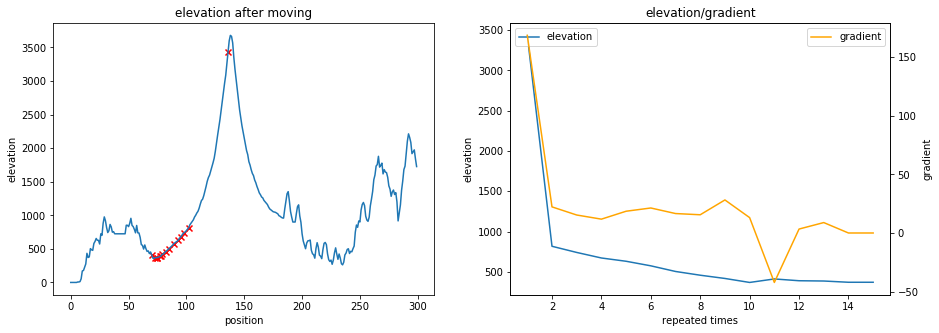

In [7]:
fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(fuji[:, 0], fuji[:, 3], label='elevation')
ax1.scatter(position_list, [fuji[x, 3] for x in position_list], color='red', marker='x', label='movement_points')
ax1.set_xlabel('position')
ax1.set_ylabel('elevation')

# グラフタイトルの設定
ax1.set_title('elevation after moving')

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(list(range(1, len(position_list)+1)), [fuji[x, 3] for x in position_list], label='elevation')

ax3 = ax2.twinx()
ax3.plot(list(range(1, len(position_list)+1)), [calc_gradient(x) for x in position_list], linestyle='-', color='orange', label='gradient')

# ax2.plot(list(range(1, len(position_list)+1)), [calc_gradient(x) for x in position_list], label='gradient')
ax2.set_xlabel('repeated times')
ax2.set_ylabel('elevation')
ax3.set_ylabel('gradient')

# グラフタイトルの設定
ax2.set_title('elevation/gradient')

# 凡例の設定
ax2.legend(loc='upper left')
ax3.legend(loc='upper right')

plt.show()

**【問題6】初期値の変更**  
問題4では最初の「今いる地点」を136としましたが、これを他の全ての点で計算してください。そして、いくつかの初期値に対してどのような下山過程となるか、問題5のように可視化してください。機械学習においては 初期値 をどう設定するかが結果に影響を与えることが確認できます。  

《初期値とは》  
今回の例での最初の地点のような値を初期値と呼びます。これを変更すると結果が変化します。例えば136と142では富士山の異なるの斜面を下ることになります。

In [8]:
position_list_0to299 = []
for now_position in range (300):
    position_list = calc_climb_down_list(now_position, alpha=0.2)
    position_list_0to299.append(position_list)

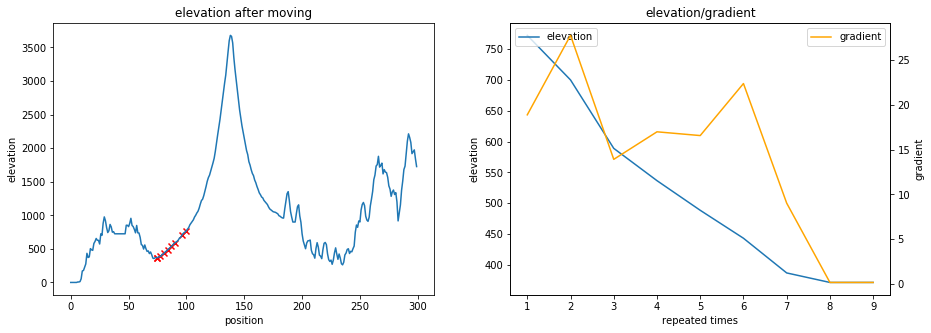

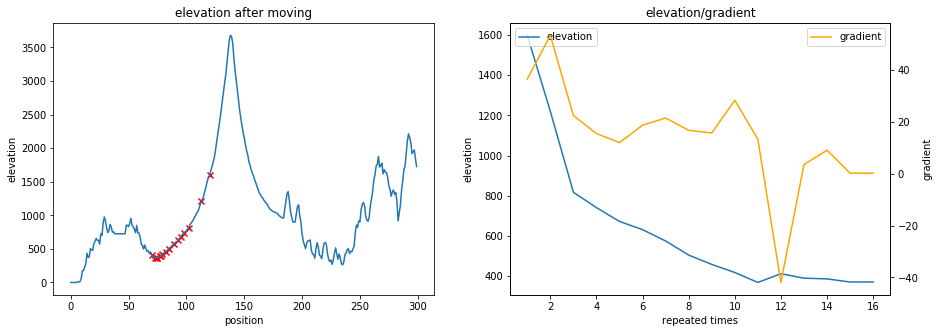

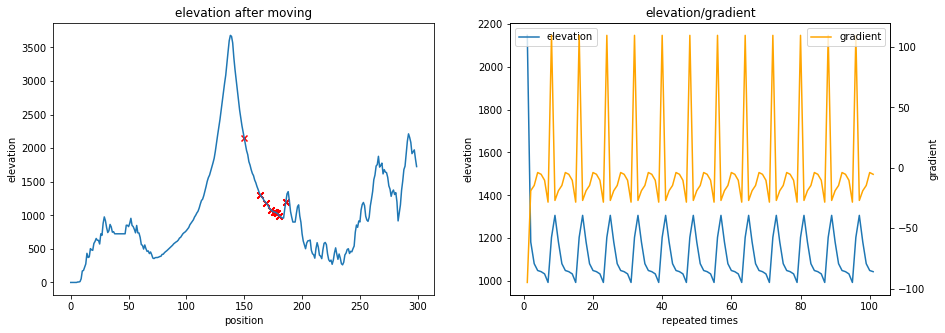

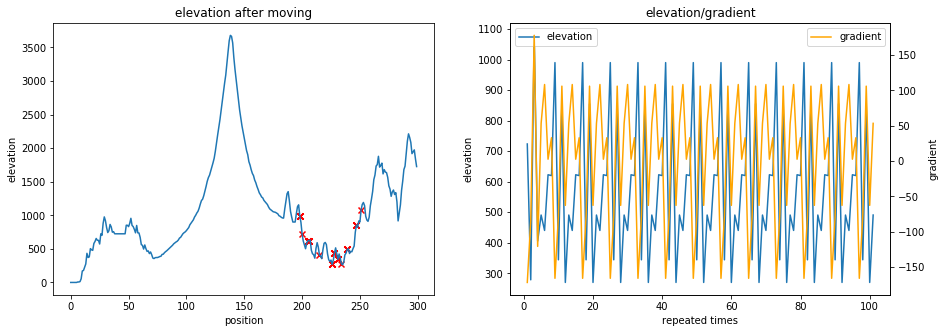

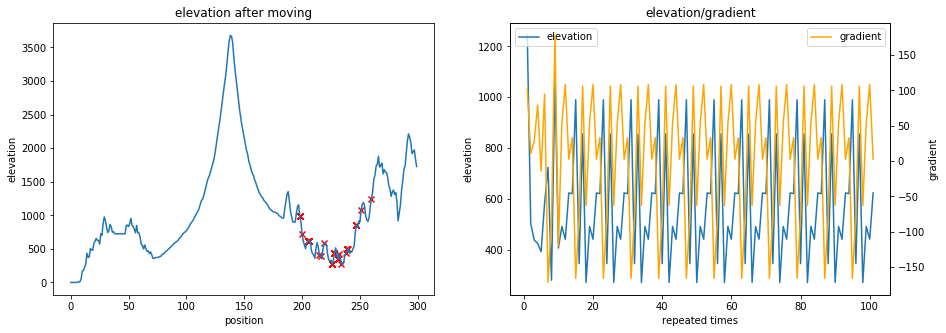

In [9]:
def plot_2grahs(now_position_list, position_list_0to299):
    for x in now_position_list:
        position_list = position_list_0to299[x]
        fig = plt.figure(figsize=(15,5))

        ax1 = fig.add_subplot(1, 2, 1)
        ax1.plot(fuji[:, 0], fuji[:, 3], label='elevation')
        ax1.scatter(position_list, [fuji[x, 3] for x in position_list], color='red', marker='x', label='movement_points')
        ax1.set_xlabel('position')
        ax1.set_ylabel('elevation')

        # グラフタイトルの設定
        ax1.set_title('elevation after moving')

        ax2 = fig.add_subplot(1, 2, 2)
        ax2.plot(list(range(1, len(position_list)+1)), [fuji[x, 3] for x in position_list], label='elevation')

        ax3 = ax2.twinx()
        ax3.plot(list(range(1, len(position_list)+1)), [calc_gradient(x) for x in position_list], linestyle='-', color='orange', label='gradient')

        # ax2.plot(list(range(1, len(position_list)+1)), [calc_gradient(x) for x in position_list], label='gradient')
        ax2.set_xlabel('repeated times')
        ax2.set_ylabel('elevation')
        ax3.set_ylabel('gradient')

        # グラフタイトルの設定
        ax2.set_title('elevation/gradient')

        # 凡例の設定
        ax2.legend(loc='upper left')
        ax3.legend(loc='upper right')

        plt.show()

chosen_positions = [100, 120, 150, 200, 260]
plot_2grahs(chosen_positions, position_list_0to299)

**【問題7】（アドバンス問題）ハイパーパラメータの変更**  
ハイパーパラメータαを変化させるとどのような下山過程となるか、問題5のように可視化してください。  
そして、ハイパーパラメータにより結果が大きく異なることを確認してください。

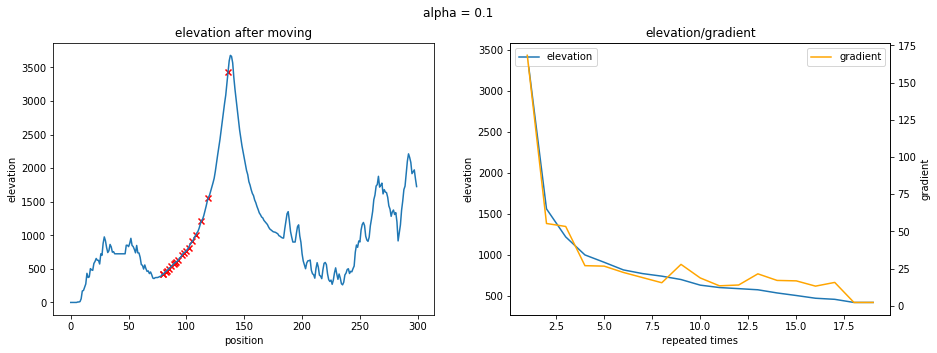

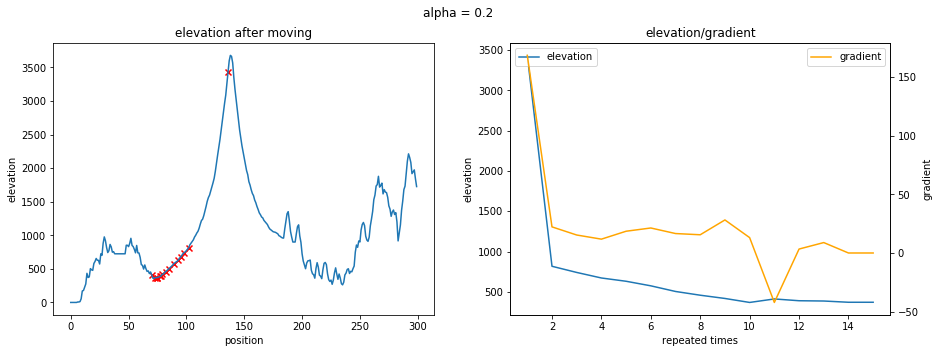

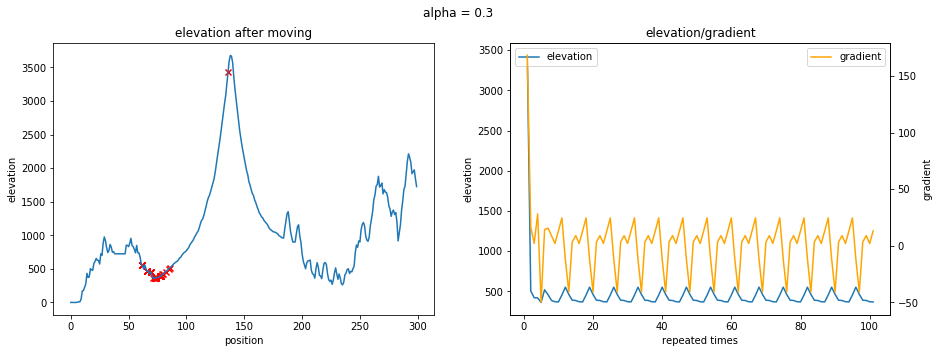

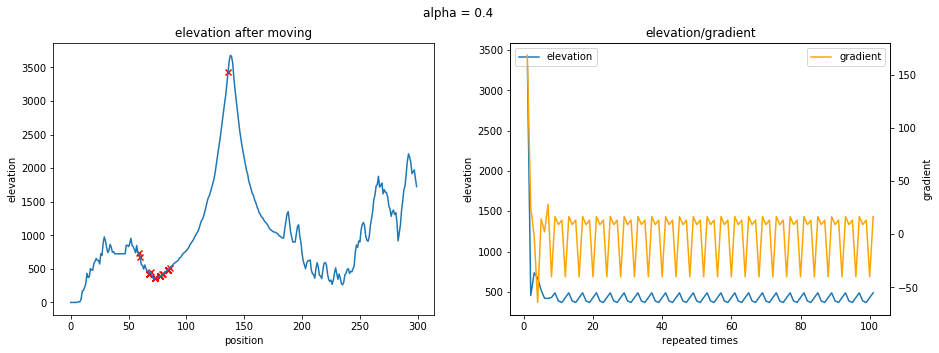

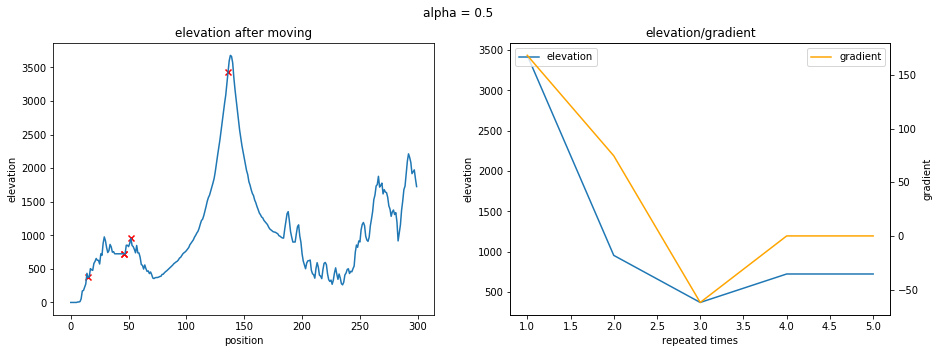

In [10]:
alpha_list = [0.1, 0.2, 0.3, 0.4, 0.5]

for alpha in alpha_list:
    position_list = calc_climb_down_list(136, alpha=alpha)
    fig = plt.figure(figsize=(15,5))

    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(fuji[:, 0], fuji[:, 3], label='elevation')
    ax1.scatter(position_list, [fuji[x, 3] for x in position_list], color='red', marker='x', label='movement_points')
    ax1.set_xlabel('position')
    ax1.set_ylabel('elevation')

    # グラフタイトルの設定
    ax1.set_title('elevation after moving')

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(list(range(1, len(position_list)+1)), [fuji[x, 3] for x in position_list], label='elevation')

    ax3 = ax2.twinx()
    ax3.plot(list(range(1, len(position_list)+1)), [calc_gradient(x) for x in position_list], linestyle='-', color='orange', label='gradient')

    # ax2.plot(list(range(1, len(position_list)+1)), [calc_gradient(x) for x in position_list], label='gradient')
    ax2.set_xlabel('repeated times')
    ax2.set_ylabel('elevation')
    ax3.set_ylabel('gradient')

    # グラフタイトルの設定
    ax2.set_title('elevation/gradient')

    # 凡例の設定
    ax2.legend(loc='upper left')
    ax3.legend(loc='upper right')
    
    fig.suptitle("alpha = " + str(alpha))

    plt.show()